# PyTorch Water Pixel Semantic Segmentation

### Procedure
* Preprocess our 4km x 4km labeled Sentinel-2 satellite data into 64 x 64 pixel tiles.
* Then split the dataset into training testing and validation sets and normalize all channel values using the mean and std on the training set.
* We will then input our preprocessed data into a PyTorch UNet model for learning water semantic segmentation.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from glob import glob
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from pathlib import Path
import re
import sys

### Dataset Preprocessing

Our Sentinel-2 images come in 4km x 4km tiles that is roughly 400 x 400 pixels in shape. For training our model, we will want to preprocess our image data into 64 x 64 tiles first.

In [2]:
import logging

logger = logging.getLogger('preprocessing')
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(formatter)
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)
logger.propagate = False

In [3]:
def preprocess(sample_dir='samples_200_5_4_35/', labels_dir='labels/', na_threshold=0.4, keep_old=True):
    """Generates 64 x 64 image and label patches from sample dataset"""
    Path('labels64/').mkdir(parents=True, exist_ok=True)
    Path('samples64/').mkdir(parents=True, exist_ok=True)

    for label_file in glob(labels_dir + '*.tif'):
        p = re.compile('label_(\d{8})_(.+).tif')
        m = p.search(label_file)

        if m:
            tile_date = m.group(1)
            eid = m.group(2)
        else:
            logger.info(f'Skipping {label_file}...')
            continue

        with rasterio.open(label_file) as src:
            label_raster = src.read([1, 2, 3])
            # if label has any values != 0 or 255 then print to log!
            if np.any((label_raster > 0) & (label_raster < 255)):
                logger.debug(f'{label_file} values are not 0 or 255.')
                
            label_binary = np.where(label_raster[0] != 0, 1, 0)

            HEIGHT = src.height
            WIDTH = src.width

        tci_file = sample_dir + f'{eid}/tci_{tile_date}_{eid}.tif'
        b08_file = sample_dir + f'{eid}/b08_{tile_date}_{eid}.tif'
        ndwi_file = sample_dir + f'{eid}/ndwi_{tile_date}_{eid}.tif'

        with rasterio.open(tci_file) as src:
            tci_raster = src.read()

        with rasterio.open(b08_file) as src:
            b08_raster = src.read()

        with rasterio.open(ndwi_file) as src:
            ndwi_raster = src.read()

            # change missing value
            ndwi_raster[ndwi_raster == -999999.0] = -999.0
            
        # break each sample up into 64 x 64 tiles and save
        for i in range(0, HEIGHT // 64):
            for j in range(0, WIDTH // 64):
                if keep_old and Path(f'samples64/sample_{tile_date}_{eid}_{i}_{j}.tif').exists() \
                    and Path(f'labels64/label_{tile_date}_{eid}_{i}_{j}.tif').exists():
                    continue
                    
                tci_tile = tci_raster[:, i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64]
                # skip if missing values exceed threshold
                na_percent = (np.count_nonzero(tci_tile[0] == 0) / tci_tile[0].size)
                if na_percent > na_threshold:
                    logger.info(f'Skipping tile {i}, {j} of {label_file} due to {na_percent} NA percentage.')
                    continue
                tci_tile = (tci_tile / 255).astype(np.float32)

                b08_tile = b08_raster[:, i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64]
                b08_tile = b08_tile.astype(np.float32)

                ndwi_tile = ndwi_raster[:, i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64]
                ndwi_tile = ndwi_tile.astype(np.float32)

                label_tile = label_binary[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64]
                label64 = label_tile.astype(np.uint8)

                tile64 = np.vstack((tci_tile, b08_tile, ndwi_tile), dtype=np.float32)

                # save 64 x 64 tile to tif file
                with rasterio.open(f'samples64/sample_{tile_date}_{eid}_{i}_{j}.tif', 'w', driver='Gtiff', count=5, height=64, width=64, dtype=np.float32) as dst:
                    dst.write(tile64)
                    
                with rasterio.open(f'labels64/label_{tile_date}_{eid}_{i}_{j}.tif', 'w', driver='Gtiff', count=1, height=64, width=64, dtype=np.uint8) as dst:
                    dst.write(label64, 1)

In [4]:
preprocess(keep_old=True)

/home/dma/miniconda3/envs/floodmaps/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/dma/miniconda3/envs/floodmaps/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


2023-12-29 13:37:37,315 - preprocessing - INFO - Skipping tile 0, 0 of labels/label_20160314_20160311_451_838.tif due to 1.0 NA percentage.
2023-12-29 13:37:37,320 - preprocessing - INFO - Skipping tile 0, 1 of labels/label_20160314_20160311_451_838.tif due to 0.556396484375 NA percentage.
2023-12-29 13:37:37,328 - preprocessing - INFO - Skipping tile 1, 0 of labels/label_20160314_20160311_451_838.tif due to 1.0 NA percentage.
2023-12-29 13:37:37,336 - preprocessing - INFO - Skipping tile 2, 0 of labels/label_20160314_20160311_451_838.tif due to 0.9931640625 NA percentage.
2023-12-29 13:37:37,344 - preprocessing - INFO - Skipping tile 3, 0 of labels/label_20160314_20160311_451_838.tif due to 0.781494140625 NA percentage.
2023-12-29 13:37:37,352 - preprocessing - INFO - Skipping tile 4, 0 of labels/label_20160314_20160311_451_838.tif due to 0.53271484375 NA percentage.


### Create Custom Dataset and DataLoader

In [5]:
# Create custom Dataset objects to input into DataLoader!!!
class FloodSampleDataset(Dataset):
    def __init__(self, sample_dir, labels_dir, transform=None):
        self.sample_dir = sample_dir
        self.labels_dir = labels_dir
        self.labels_path = glob(labels_dir + '/label_*.tif')
        self.transform = transform

    def __len__(self):
        return len(self.labels_path)

    @staticmethod
    def read_image(filename):
        """Reads a TIF image into a N x H x W Tensor given N channels."""
        with rasterio.open(filename) as src:
            raster = src.read()
    
        tensor = torch.from_numpy(raster)
        return tensor
        
    def __getitem__(self, idx):
        label_path = self.labels_path[idx]
        p = re.compile('label_(.+\.tif)')
        m = p.search(label_path)

        if m:
            sample_path = self.sample_dir + '/sample_' + m.group(1)
            image = self.read_image(sample_path)
            label = self.read_image(label_path) # ensure label tensor is of type torch.uint8
        else:
            raise Exception("Improper label path name")

        if self.transform:
            image = self.transform(image)
            
        return image, label

With the dataset loaded, we want to calculate the mean and standard deviation for each channel of the training set and standardize the entire dataset.

In [6]:
val_percent = 0.25
dataset = FloodSampleDataset('samples64', 'labels64')
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))

loader = DataLoader(train_set,
                    batch_size=10,
                    num_workers=0,
                    shuffle=False)

# calculate total mean and std for each channel not including missing values
pixel_count = 0
sum = torch.zeros(5, dtype=torch.float64)
for samples, _ in loader:
    # first stack all feature values from batch together
    channels = samples.size(1)
    samples = torch.transpose(samples, 0, 1)
    samples = samples.reshape(channels, -1)

    # mask out missing values and calculate mean for each channel
    mask = (samples[0] != 0)
    pixel_count += mask.sum()
    for i in range(channels):
        sum[i] += samples[i][mask].sum()
mean = sum / pixel_count

# add up variance for each channel not including missing values
tot_var = torch.zeros(5, dtype=torch.float64)
for samples, _ in loader:
    # first stack all feature values from batch together
    channels = samples.size(1)
    samples = torch.transpose(samples, 0, 1)
    samples = samples.reshape(channels, -1)

    mask = (samples[0] != 0)
    for i in range(channels):
        tot_var[i] += ((samples[i][mask] - mean[i]) ** 2).sum()
std = torch.sqrt(tot_var / (pixel_count - 1))

print('Training channel means:', mean)
print('Training channel stds:', std)

standardize = transforms.Compose([transforms.Normalize(mean, std)])

# set transform to 0 mean and unit std
dataset.transform = standardize

Training channel means: tensor([ 1.9971e-01,  2.3525e-01,  1.5936e-01,  1.4244e+03, -8.3591e-02],
       dtype=torch.float64)
Training channel stds: tensor([1.8662e-01, 1.7717e-01, 1.6218e-01, 1.2835e+03, 5.8181e-01],
       dtype=torch.float64)


Let's take a look at some of our 64 x 64 tiles in the training dataset.

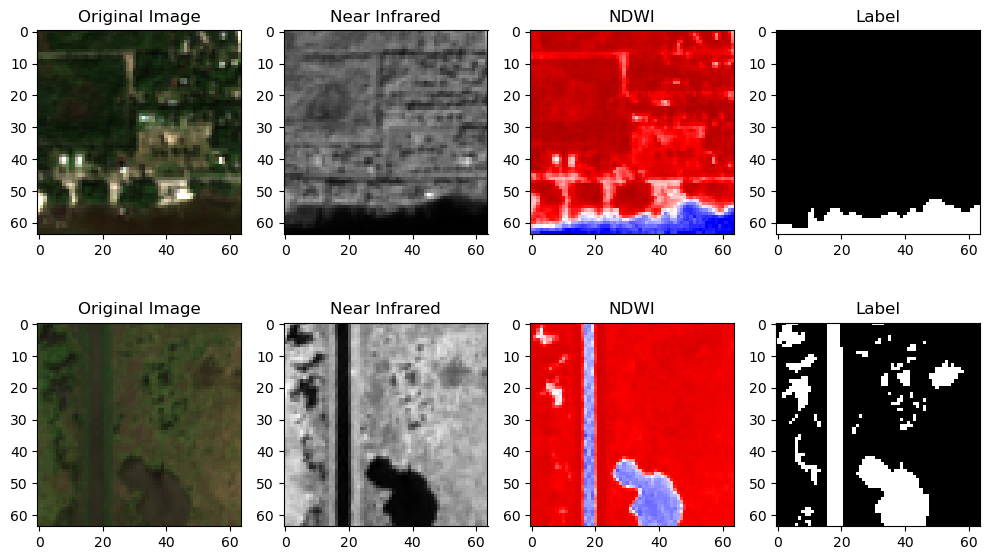

In [123]:
plt.figure(figsize=(10, 6))
for i in range(0,2):
    example = train_set[i][0].numpy().transpose((1, 2, 0))
    example = std * example + mean
    tci = example[:, :, :3]
    tci = np.clip(tci, 0, 1)
    b08 = example[:, :, 3]
    ndwi = example[:, :, 4]
    
    label = train_set[i][1].numpy().transpose((1, 2, 0))
    
    plt.subplot(2,4,4*i+1)
    plt.imshow(tci)
    plt.title('Original Image')

    plt.subplot(2,4,4*i+2)
    plt.imshow(b08, cmap='gray')
    plt.title('Near Infrared')

    plt.subplot(2,4,4*i+3)
    plt.imshow(ndwi, cmap='seismic_r', vmin=-1, vmax=1)
    plt.title('NDWI')

    plt.subplot(2,4,4*i+4)
    plt.imshow(label, cmap='gray', vmin=0, vmax=1)
    plt.title('Label')
    
plt.tight_layout()
plt.show()

Now with our data preprocessed and standardized, we are ready to train our model!

### UNet Implementation

In [7]:
from torch import nn
from torcheval.metrics import BinaryAccuracy

In [8]:
class DoubleConv2d(nn.Module):
    """Convolution layer followed by batch normalization and ReLU, done twice."""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UpConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.drop = nn.Dropout(p=0.5)
        self.conv = DoubleConv2d(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x3 = torch.cat([x1, x2], dim=1)
        x4 = self.drop(x3)
        return self.conv(x4)

class UNet(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.n_channels = n_channels

        self.conv1 = (DoubleConv2d(n_channels, 16))
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(p=0.25)

        self.conv2 = (DoubleConv2d(16, 32))
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(p=0.5)

        self.conv3 = (DoubleConv2d(32, 64))
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(p=0.5)

        self.conv4 = (DoubleConv2d(64, 128))
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(p=0.5)

        self.convm = (DoubleConv2d(128, 256))

        self.upconv4 = UpConv2d(256, 128)
        self.upconv3 = UpConv2d(128, 64)
        self.upconv2 = UpConv2d(64, 32)
        self.upconv1 = UpConv2d(32, 16)

        # output layer
        self.out = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        out = self.pool1(x1)
        out = self.drop1(out)
        x2 = self.conv2(out)
        out = self.pool2(x2)
        out = self.drop2(out)
        x3 = self.conv3(out)
        out = self.pool3(x3)
        out = self.drop3(out)
        x4 = self.conv4(out)
        out = self.pool4(x4)
        out = self.drop4(out)
        x5 = self.convm(out)

        x = self.upconv4(x5, x4)
        x = self.upconv3(x, x3)
        x = self.upconv2(x, x2)
        x = self.upconv1(x, x1)
        logits = self.out(x)
        
        return logits

In [ ]:
x1 = torch.rand(5, 64, 64)
x2 = torch.rand(5, 64, 64)
torch.

Model summary:

In [16]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
unet = UNet(5).to(device)

Using cpu device


In [9]:
print(f"Model structure: {unet}\n\n")

Model structure: UNet(
  (conv1): DoubleConv2d(
    (double_conv): Sequential(
      (0): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2): DoubleConv2d(
    (double_conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4)

Let's train our UNet model...

In [10]:
import wandb
from datetime import datetime

In [11]:
wandb.login()

wandb: Currently logged in as: davidma. Use `wandb login --relogin` to force relogin


True

In [14]:
# get our optimizer and metrics
def train_loop(dataloader, model, device, loss_fn, optimizer):
    running_loss = 0.0
    num_batches = len(dataloader)
    metric = BinaryAccuracy(threshold=0.5)

    model.train()
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        logits = model(X)

        loss = loss_fn(logits, y.float())
        loss.backward()
        optimizer.step()

        metric.update(nn.functional.sigmoid(logits).flatten(), y.float().flatten())
        running_loss += loss.item()

    # wandb tracking loss and accuracy per epoch
    epoch_accuracy = metric.compute()
    epoch_loss = running_loss / num_batches
    wandb.log({"train accuracy": epoch_accuracy, "train loss": epoch_loss})

    return epoch_loss

def test_loop(dataloader, model, device, loss_fn):
    running_vloss = 0.0
    num_batches = len(dataloader)
    metric = BinaryAccuracy(threshold=0.5)
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            logits = model(X)
            running_vloss += loss_fn(logits, y.float()).item()
            metric.update(nn.functional.sigmoid(logits).flatten(), y.float().flatten())

    epoch_vaccuracy = metric.compute()
    epoch_vloss = running_vloss / num_batches
    wandb.log({"val accuracy": epoch_vaccuracy, "val loss": epoch_vloss})

    return epoch_vloss

def train(train_set, val_set, model, device, epochs=5, batch_size=16, learning_rate=1e-5, save='model'):
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f'''Starting training:
        Date:            {timestamp}
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device}
    ''')

    # log via wandb
    wandb.init(
        project="FloodSamplesUNet",
        config={
        "learning_rate": learning_rate,
        "architecture": "CNN",
        "dataset": "Sentinel2",
        "epochs": epochs,
        "batch_size": batch_size,
        "val_percent": val_percent
        }
    )
    
    # initialize loss function
    loss_fn = nn.BCEWithLogitsLoss()

    # optimizer and scheduler for reducing learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)

    # make DataLoader
    train_loader = DataLoader(train_set,
                             batch_size=batch_size,
                             num_workers=0,
                             shuffle=True,
                             drop_last=False)
    
    val_loader = DataLoader(val_set,
                            batch_size=batch_size,
                            num_workers=0,
                            shuffle=True,
                            drop_last=False)

    # TRAIN AND TEST LOOP IS PER EPOCH!!!
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        # train loop
        avg_loss = train_loop(train_loader, model, device, loss_fn, optimizer)

        # at the end of each training epoch compute validation
        avg_vloss = test_loop(val_loader, model, device, loss_fn)

        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Save our model
    PATH = 'models/' + save + '.pth'
    torch.save(model.state_dict(), PATH)

    wandb.finish()

In [18]:
# training
train(train_set, val_set, unet, device, epochs=40, batch_size=10, learning_rate=1e-5, save='model3')

Starting training:
        Date:            2023-12-29 14:19:14
        Epochs:          40
        Batch size:      10
        Learning rate:   0.001
        Training size:   437
        Validation size: 145
        Device:          cpu
    


Epoch 1
-------------------------------


/home/dma/miniconda3/envs/floodmaps/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


LOSS train 0.45879094234921713 valid 0.701974109808604
Epoch 2
-------------------------------
LOSS train 0.2825267745012587 valid 0.6172361056009928
Epoch 3
-------------------------------
LOSS train 0.25863143225962465 valid 0.5456393400828043
Epoch 4
-------------------------------
LOSS train 0.18610971827398648 valid 0.5821776429812113
Epoch 5
-------------------------------
LOSS train 0.16373884745619513 valid 0.5330403506755829
Epoch 6
-------------------------------
LOSS train 0.14541117000308904 valid 0.48520797689755757
Epoch 7
-------------------------------
LOSS train 0.13159156929362903 valid 0.4987224300702413
Epoch 8
-------------------------------
LOSS train 0.12224763530221852 valid 0.8338409960269928
Epoch 9
-------------------------------
LOSS train 0.1048723819072951 valid 0.5454816917578379
Epoch 10
-------------------------------
LOSS train 0.10115215935829011 valid 0.9481448531150818
Epoch 11
-------------------------------
LOSS train 0.095983154902404 valid 0.847

train accuracy,▁▇▅▇▇▇▇▇▇▇▇▇█▇███▇█▇████▇██▇▇▆▇█▇█▇█████
train loss,█▅▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁
val accuracy,▁▁▁▁▁▆▁▁▁▁▁▁▇▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▃█▃▁
val loss,▃▃▃▃▃▂▃▄▃▅▄▃▂▃▃▅▁▃▃▅▄▅▅▄▃▄▃▇▂▇█▆▄▄▁▂▂▁▂▃
train accuracy,0.98215
train loss,0.05778
val accuracy,0.61535
val loss,0.63323


In [36]:
# plot prediction results for test data
pred_unet = UNet(5)
pred_unet.load_state_dict(torch.load('models/model2.pth'))

<All keys matched successfully>

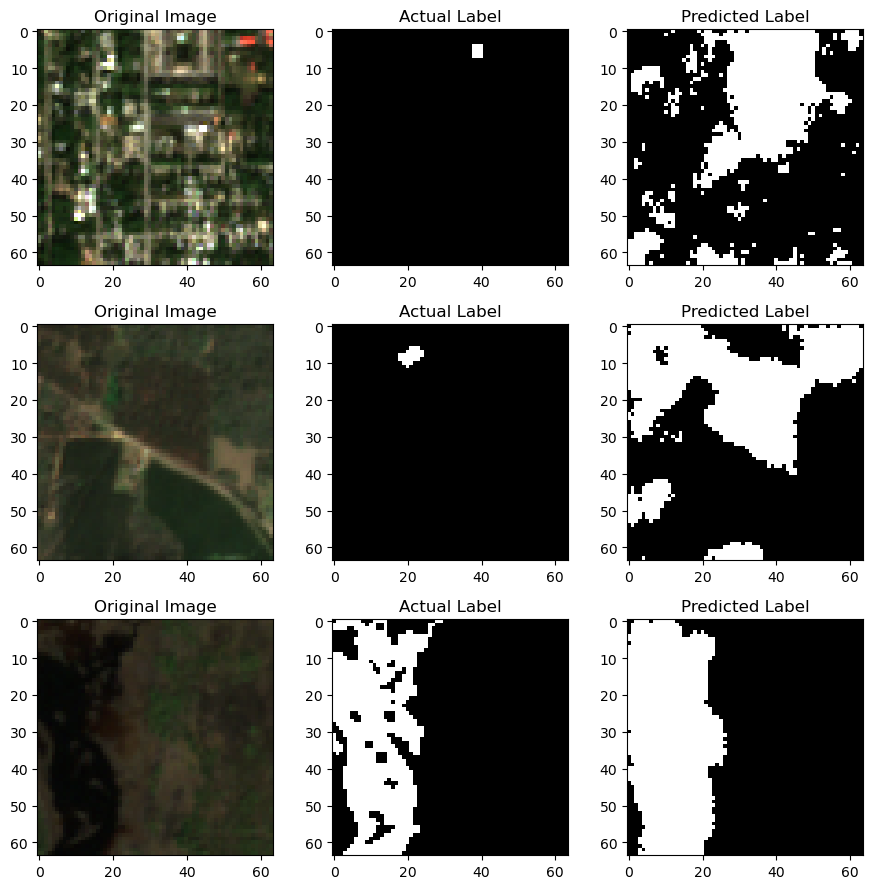

In [37]:
plt.figure(figsize=(8, 8))
for i in range(0,3):
    test_X = val_set[i][0]
    test_y = val_set[i][1]
    logits = pred_unet(test_X.unsqueeze(0))
    pred_y = torch.where(nn.functional.sigmoid(logits) > 0.5, 1.0, 0.0)
    
    tci = test_X.numpy().transpose((1, 2, 0))
    tci = std * tci + mean
    tci = tci[:, :, :3]
    tci = np.clip(tci, 0, 1)
    actual_label = test_y.numpy()[0]
    pred_label = pred_y.numpy()[0][0]
    
    plt.subplot(3,3,3*i+1)
    plt.imshow(tci)
    plt.title('Original Image')

    plt.subplot(3,3,3*i+2)
    plt.imshow(actual_label, cmap='gray', vmin=0, vmax=1)
    plt.title('Actual Label')

    plt.subplot(3,3,3*i+3)
    plt.imshow(pred_label, cmap='gray', vmin=0, vmax=1)
    plt.title('Predicted Label')
    
plt.tight_layout()
plt.show()